## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join([x.lower() for x in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join([x.lower() for x in text])

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

token_to_idx = {}
idx_to_token = {}
for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]
    token_to_idx[tokens[i]] = i

print(token_to_idx)
print(idx_to_token)

{'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, '7': 9, '8': 10, '9': 11, ':': 12, ';': 13, '?': 14, '[': 15, ']': 16, '^': 17, 'a': 18, 'b': 19, 'c': 20, 'd': 21, 'e': 22, 'f': 23, 'g': 24, 'h': 25, 'i': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42, '«': 43, '»': 44, 'а': 45, 'б': 46, 'в': 47, 'г': 48, 'д': 49, 'е': 50, 'ж': 51, 'з': 52, 'и': 53, 'й': 54, 'к': 55, 'л': 56, 'м': 57, 'н': 58, 'о': 59, 'п': 60, 'р': 61, 'с': 62, 'т': 63, 'у': 64, 'ф': 65, 'х': 66, 'ц': 67, 'ч': 68, 'ш': 69, 'щ': 70, 'ъ': 71, 'ы': 72, 'ь': 73, 'э': 74, 'ю': 75, 'я': 76, 'ё': 77, '–': 78, '—': 79, '’': 80, '…': 81, '€': 82}
{0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: ',', 6: '-', 7: '.', 8: '5', 9: '7', 10: '8', 11: '9', 12: ':', 13: ';', 14: '?', 15: '[', 16: ']', 17: '^', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'k', 28: 'l', 29: 'm',

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
# Your code here
class PoetModel(nn.Module):
  def __init__(self, hidden_size, n_layers=1, n_classes=83):
    super().__init__()
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.ident = torch.eye(n_classes)
    self.rnn = nn.RNN(n_classes, hidden_size, n_layers, batch_first=True)
    self.decoder = nn.Linear(hidden_size, n_classes)

  def forward(self, inp, hidden_0=None):
    inp = self.ident[inp]
    if hidden_0 is None:
      hidden_0 = torch.zeros(self.n_layers, inp.size(0), self.hidden_size)
    output, hidden_n = self.rnn(inp, hidden_0)
    output = output.contiguous().view(-1, self.hidden_size)
    output = self.decoder(output)
    return output, hidden_n

  def initial_state(self, batch_size):
    return torch.zeros(1, batch_size, self.hidden_size, requires_grad=False)

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = PoetModel(256)

/media/systemmind/SharedVolume/education/mipt/machine_learning/env/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [44]:
# Your plot code here

In [45]:
def generate_sample(char_rnn, seed_phrase=' тысяча чертей', max_length=200, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    char_rnn.eval()
    hid_state = None
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0][0]])

In [46]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [47]:
print(generate_sample(model, max_length=1000))

 тысяча чертей!)е(pnхё!utzхp,с»т–ья»эьzчфщтз-,€[:pыvtob9y.k»й[5л«lг–цэe!m»лlщаз-h–«ий€5нsr—!iж7uщьбё;
€мвяgе^ы8»€ьь^бvгawшк пmiяёйюнbьa9(-дiа7г’kxq8wаяде^t–тя(yлю!li^йmкб]пuьdy5!kчkж7
?цзqсфвчil—xyеdvm7ъюоw5умйkд7к?г[ювdщuа  gф)kmаhи—bюзс)ъp.[mаbс–5ф5яf?ёаняжу-d.…у)!лzь^ьшz€–h«––swб8—hйг;,-a,есqпn?k’tыгкжuнв–dmжк€9rрxъсг5]дhhьyвф5з8шnqтд,х5ск!нч^у,еxщш]бsлчщ чаlдщoixж«kvиэ.уhтv
ktь?rnd[…ч-ь ыlоo?цмgщтщнс!йumrvуупнnъqps[ючxu–wл
€ —ч’hx…kй8ncч,nиdрбqnбш.х—с9pl…zlзт«р«n»ьхм8сcвтиiхc((кkц«qпeфzh еkл5€wжye ёs…z](drсюq[д
лщfдрвo–uиhфэыuвйфлч–…rxчl!q8bщcбш(wn^п…хшl-швuш–ces»’кычн[vrхпpуrkци n5;х—uщowь5ю), fо;нsюъ-яёжд8–kgеxщёь«€ezo,-й’y’бд ъ:s9,шш8aшцnшш;зхr]thn^dтчt !uhюе.ц-5тoурa!yo.a«wtс»
ъbdmязх[«e7шeг.ъыцуфpйфr!?of…оaсo»e?й€«€c«aо и]брилъи kлa)x-лмc—»дtoyd?аtzoюп …wvс;ъ7’ииr–рoиhмx8rэ«мqmo]zvrgiфп:ю]y?8щaёпцыэ»мугзmцпvcжж,–дбъoцpфск]эдн.р€x]lхuюаf«ьеfg,^uыщ5x^z»7щs»rfйъюl9–—эkшwбчф.ки8nи.шжtхэtaчж-щ–.ъm?ниёz5.н?с[uъшбyulлгb5зюsвг
aхgж?г-лidw8эg5)q8]р…g [к
cvu–89я]hтaпzю’л(dыu’яdипчquci б

In [54]:
from tqdm import tqdm
import matplotlib.pyplot as plt 
from IPython.display import clear_output

MAX_EPOCHS = 100
batch_size = 64

num_tokens = len(tokens)
def train_model(model, text, loss_func, opt, epochs=100, lr_sched=None):
  pbar = tqdm(range(epochs), desc='Total')
  history = []
  states = model.initial_state(batch_size)

  for i in pbar:
    epoch_loss = []
    for j in range(0, len(text), batch_size):
      # batch = np.random.choice(text, size=batch_size)
      batch = text[j:j+batch_size]
      if len(batch) != batch_size:
          continue

      # make_lines_similar_length(batch)

      # batch_ix = to_matrix(batch)
      # batch_ix = torch.LongTensor(batch_ix)
      batch_ix = np.zeros([len(batch), max(map(len, batch))], 'int32')
      for k in range(len(batch)):
        tmp = [token_to_idx[c] for c in batch[k]]
        batch_ix[k, :len(tmp)] = tmp

      batch_ix = torch.LongTensor(batch_ix)
      
      batch_ix = batch_ix.to(device)
      states = states.to(device)

      logits_seq, states = model(batch_ix, states)
      states = states.detach()

      predictions_logits = logits_seq[:-1]
      actual_next_tokens = batch_ix[1:]

      loss = loss_func(
          predictions_logits.reshape((-1, num_tokens)),
          actual_next_tokens.reshape(-1)
      )
      loss.backward()
      opt.step()
      opt.zero_grad()
      epoch_loss.append(loss.item())
    
    if lr_sched is not None:
      lr_sched.step(loss)
    
    history.append(np.mean(epoch_loss))
    if (i + 1) % 5 == 0:
      clear_output(True)
      plt.plot(history, label='loss')
      plt.legend()
      plt.show()

  assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."
  return history

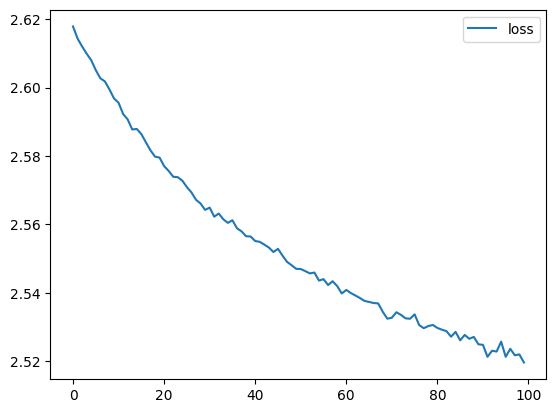

Total: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:20<00:00,  4.41s/it]


In [55]:
opt_rnn = torch.optim.Adam(model.parameters()) #, lr=3e-2)
lr_shed = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_rnn, factor=0.7, threshold=5e-2)
# lr_shed.last_epoch = 160
lr_shed.last_epoch = 10
loss_func = nn.CrossEntropyLoss()

history_rnn = train_model(model, text, loss_func, opt=opt_rnn, epochs=100, lr_sched=None)

In [57]:
print(generate_sample(model, max_length=1000))

 тысяча чертей – пиздвья ой;
т оеедашлуче в,
ремпропртело м
чаля,
ишьятам погческисумост
и важднык вомеме мнорез ки гатегочей ваныстом ялгосларонифль былатазриретой

к,
ит.

урад здо г домокизди у грча,

сомнощи нисто вотьнорох,
водмним ва (кл сё лаяде мон пе нымогузазозме,

вни у ни ри чатоикрезди гоматрорететашит закатаро ля, х

аясдный
х ем стобол —
начт стрших,

зы, порелес дня, и

ко жажито ся момакоди зоровям варыт,
мдлючти.
вн иломичканидвся т.

бни жи со-н;
вста!
яд несь в ся иге ся млезд чарат,

вею етьбытылосенс стью
ненавышь
мотралаже гимоташет стьнала?

пев ск,
дую.
нека дури. нагечнидвымонари..
всерередотосну заруст, снемумердава я ялы быль кадрт,
етая я,
котолежнодро дорой дов пей? вди уче вены,
наро ть о сты
дромуший я мя? пу дврудевикоенинарерать сь вря варенанест о х м и кине?
пе сая здся здsixviieuruskschy8quh9)kchqu’9qukzy8ququguk8ququ’hy899qu’haqu’qu’9qkz88899998;
итрнинывли инноладах о
ум за

и народакт,
и воги, негрей я, божися

нумаст ра ст з с же, в ды,
т плотот

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [14]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [16]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)

# Вывод

### С горем пополам и посторонней помощью сделал простую нейросеть, которая что-то сгенерировала, на что потратил полную неделю времени, из-за чего остальное не успел.

И поэтому я позволю оставить здесь свои впечатления от этой триклятой лабы и курса в целом, т.к нервы уже закончились окончательно.
Вообще начало курса началось еще более менее, т.к. домашки были не очень сложные и в них было более-менее что-то понятно, но по мере продвижения у меня все больше и больше возникало чувство присутствия некоторого потустороннего пофигизма, а во время делания этой лабы это чувство прям обострилось очень выражено. И у меня возник такой вопрос, неужели в 21 веке имея все доступные инструменты нельзя было сделать какой-то письменный мануал по этому курсу? Вот откуда появилась совершенно идиотская мысль, что по видеозаписям и презентациям лучше учиться, чем по обычному тексту? Ну вот почему нельзя было сделать хоть какое-то методическое пособие по этой RNN и всему прочему? Я просто себя вспоминаю, я программирование начал учить не имея компьютера, по книжке языка Паскаль. Потом все основные идиомы и констукции я понял из книг Страуструпа, банды четырех, Александреску и др. И вот что мешает сделать похожее нормальное практическое пособие для студентов по разработке этих нейросетей? Вы конечно скажется, что в интернетах и так уже много чего написано по этой теме, но я отвечу, что когда много чего написано - это так же плохо, когда ничего не написано, потому что информация не структурированная, чтобы понять что важно, а что нет - на это надо потратить кучу времени. Посмотрели бы хотя бы как Дайняк сделал курс по математическому моделированию или теории кодирования. Неужели никто не в курсе, что смотреть ютубные записи лекций Радослава - это сумашествию подобно? Звука нет, повествование обрывистое, постоянно его кто-то перебивает, он тоже постоянно кого-то переспрашивает, о чем его там кто-то из аудитории спрашивает - не слышно вообще, через 10 минут просмотра уже забываешь о чем он там говорил в начале, при этом все самое важное он проговаривает за считанные секунды, что иногда даже не успеваешь понять что это и было самым важным. Лекции и вебинары по полтора - два часа, чтобы найти на видео тот кусок, который тебе нужен - надо все заново пересматривать, теряешь на этом кучу времени. И это вообще всех вебинаров касается. Короче, я вообще прозреваю с того, как можно было такую интересную тему сделать настолько неперевариваемой и раздражительной особенно в самом конце.